In [1]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI-Assisted Data Science Workflows in BigQuery

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/ai-assisted-data-science/ai-assisted-data-science.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/ai-assisted-data-science/ai-assisted-data-science.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Fapplying-llms-to-data%2Fai-assisted-data-science%2Fai-assisted-data-science.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/applying-llms-to-data/ai-assisted-data-science/ai-assisted-data-science.ipynb">
      <img width="32px" src="https://raw.githubusercontent.com/primer/octicons/refs/heads/main/icons/mark-github-24.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

| Author |
| --- |
| [Jeff Nelson](https://github.com/jeffonelson) |

## Overview

In this notebook, you'll explore a multimodal data science workflow in BigQuery. You will start with a raw dataset of house listings, enrich it with AI, build a clustering model to find customer segments, and finally, build a powerful text-to-image and image-to-image search engine.

Next, you'll compare this SQL-native workflow with a modern, generative AI approach by using the [Data Science Agent](https://cloud.google.com/bigquery/docs/colab-data-science-agent) to automatically generate a Python-based clustering model from a simple text prompt.

## Objectives

*   **Prepare data** and perform feature engineering on a raw dataset.
*   **Enrich data** by using BigQuery ML's AI functions to analyze images.
*   **Build and evaluate** a K-means clustering model using BQML.
*   **Automate model creation** by using the Data Science Agent to generate a Python clustering model.
*   **Generate embeddings** for house images using a multimodal model.
*   **Perform vector search** to find similar houses using text or image queries.

## Setup

Before you can begin the analysis, you need to set up your environment. This involves enabling the necessary APIs, creating a resource connection for BigQuery, and configuring permissions for the service account that connection will use.

### Create BigQuery Cloud resource connection

Create a [Cloud resource connection](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection). This connection acts as a secure bridge between BigQuery and other Google Cloud services. It allows BigQuery to call the Gemini models hosted on Vertex AI for inference and data enrichment.

In [2]:
!bq mk --connection --location=us --connection_type=CLOUD_RESOURCE ai_connection

Connection 35440820017.us.ai_connection successfully created


### Configure environment and grant permissions

The next block of code handles the necessary setup for your environment. These cells perform several key actions:

*   **Capture variables:** Your `PROJECT_ID` and the connection's service account email are captured as Python variables.
*   **Initialize a GCS client:** A connection to Google Cloud Storage is created so you can access the house listing images.
*   **Grant permissions:** The necessary IAM roles ([`Storage Object Viewer`](https://cloud.google.com/storage/docs/access-control/iam-roles#storage.objectViewer) and [`Vertex AI User`](https://cloud.google.com/vertex-ai/docs/general/access-control#aiplatform.user)) are granted to the connection's service account, allowing it to read images and call Vertex AI models.
*   **Define a helper function:** The `display_images` function is defined, which you'll use to visualize images throughout the notebook.
*   **Enable interactive tables:** A Colab extension is enabled to render pandas DataFrames as interactive tables.

In [3]:
# Create Service Account
SERVICE_ACCT = !bq show --format=prettyjson --connection us.ai_connection | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]
print(SERVICE_ACCT_EMAIL)

bqcx-35440820017-07ft@gcp-sa-bigquery-condel.iam.gserviceaccount.com


In [4]:
# Set project id variables for Python and Shell
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
%env PROJECT_ID=$PROJECT_ID

env: PROJECT_ID=qwiklabs-gcp-03-52ef573f6140


In [5]:
from google.cloud import storage

# Define bucket containing housing images
bucket_name = "drw001-data-science-with-notebooks"
# Create Cloud Storage client
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(bucket_name)

%env BUCKET_NAME=$bucket_name

env: BUCKET_NAME=drw001-data-science-with-notebooks


In [6]:
import time

# Grant permissions
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/storage.objectViewer'
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role='roles/aiplatform.user'

# Wait ~60 seconds, to give IAM updates time to propagate. Otherwise, subsequent cells may fail.
time.sleep(60)

Updated IAM policy for project [qwiklabs-gcp-03-52ef573f6140].
Updated IAM policy for project [qwiklabs-gcp-03-52ef573f6140].


In [7]:
import io
import math

import PIL.Image
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import storage

# Helper function to display images in a DataFrame


def display_images(
    df: pd.DataFrame, uri_column: str = "uri", title_column: str | None = None
) -> None:
    """Displays images from a DataFrame in a 3-column grid.

    Args:
        df (pd.DataFrame): DataFrame with a column containing GCS URIs.
        uri_column (str): The name of the column containing the GCS URIs.
        title_column (str, optional): The name of the column to use for the image title.
                                      If None, the image filename is used.
    """
    # Calculate grid size
    num_images = len(df)
    if num_images == 0:
        print("No images to display.")
        return

    cols = 3
    rows = math.ceil(num_images / cols)

    # Handle single image case for correct subplot array shape
    if num_images == 1:
        fig, axs = plt.subplots(1, 1, figsize=(3.5, 3.5))
        axs = [axs]
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3.5))
        axs = axs.flatten()

    for i, row in df.iterrows():
        if i >= len(axs):
            break

        # 1. Extract the image path from the full GCS URI
        image_uri = row[uri_column]
        image_path = image_uri.split("/", 3)[-1]

        # 2. Get the image from GCS
        try:
            blob = bucket.blob(image_path)
            image_bytes = blob.download_as_bytes()
            image = PIL.Image.open(io.BytesIO(image_bytes))
        except Exception as e:
            print(f"Could not load image {image_uri}: {e}")
            continue

        # 3. Plot the image
        axs[i].imshow(image)

        # Determine the title
        if title_column and title_column in df.columns:
            title = f"Cluster: {row[title_column]}"
        else:
            title = image_path.split("/")[-1]

        axs[i].set_title(title, fontsize=10)
        axs[i].axis("off")

    # Hide any unused subplots
    for j in range(num_images, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

### Enable interactive tables for DataFrames

For a better data exploration experience, you can enable a [Colab extension](https://colab.sandbox.google.com/notebooks/data_table.ipynb) that renders pandas DataFrames as interactive, sortable tables. This makes it much easier to inspect large amounts of data.

In [8]:
%load_ext google.colab.data_table

---
## Data Preparation and Feature Engineering

### Create a BigQuery dataset

A [BigQuery dataset](https://cloud.google.com/bigquery/docs/datasets-intro) is a container that holds all of your other BigQuery objects, including tables, views, and models.

In [9]:
!bq mk --dataset housing_dataset

Dataset 'qwiklabs-gcp-03-52ef573f6140:housing_dataset' successfully created.


### Load the raw data into a BigQuery table

You can now load your source data using the [`bq load`](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table) command. It  directly loads a CSV file from a public Google Cloud Storage bucket into a new BigQuery table named `listings`.

In [10]:
!bq load \
    --autodetect \
    --source_format=CSV \
    --skip_leading_rows=1 \
    housing_dataset.listings \
    gs://$BUCKET_NAME/tabular/housing-data.csv

Waiting on bqjob_r6388397c413962fe_0000019c475f891a_1 ... (1s) Current status: DONE   


## Explore the data with `ML.DESCRIBE_DATA`

Next, you'll perform exploratory data analysis to understand the data's characteristics. Instead of writing many individual `COUNT`, `AVG`, and `STDDEV` queries, you can use the [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) function.

The function returns descriptive statistics for each column in a table, giving you a quick overview of distributions, missing values, and potential outliers.


In [11]:
%%bigquery --project {PROJECT_ID}

SELECT *
FROM
  ML.DESCRIBE_DATA((SELECT * FROM `housing_dataset.listings`));

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,acre_lot,80,0,0,0.1,5,1.066875,1.084981,0.6,"[0.1, 0.6, 5.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,city,80,0,<NA>,Albuquerque,Wichita,NaN,NaN,NaN,[],44,8.3875,80,"[{'value': 'San Diego', 'count': 2}]",<NA>,<NA>,NaN,<NA>,[],<NA>
2,house_uri,80,0,<NA>,gs://drw001-data-science-with-notebooks/images...,gs://drw001-data-science-with-notebooks/images...,NaN,NaN,NaN,[],80,71.8875,80,[{'value': 'gs://drw001-data-science-with-note...,<NA>,<NA>,NaN,<NA>,[],<NA>
3,id,80,0,0,1,80,40.500000,23.092206,40.0,"[1.0, 40.0, 80.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,number_of_baths,80,0,0,1,6,2.887500,1.420772,2.5,"[1.0, 2.5, 6.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
5,number_of_rooms,80,0,0,2,12,5.237500,2.651621,5.0,"[2.0, 5.0, 12.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
6,price,80,0,0,145000,1500000,626562.500000,364988.521866,560000.0,"[145000.0, 560000.0, 1500000.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
7,sale_status,80,0,<NA>,For Sale,Sold,NaN,NaN,NaN,[],2,7.0500,80,"[{'value': 'For Sale', 'count': 61}]",<NA>,<NA>,NaN,<NA>,[],<NA>
8,sq_ft,80,0,0,800,6000,2543.250000,1375.675084,2250.0,"[800.0, 2250.0, 6000.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>
9,year_built,80,0,0,1960,2024,1994.012500,18.937723,1997.0,"[1960.0, 1997.0, 2024.0]",<NA>,NaN,80,[],<NA>,<NA>,NaN,<NA>,[],<NA>


### Clean, filter, and enrich the data

Create a new, cleaned table from the raw data. The following query:

1.  **Filters the data** to include only listings that are currently 'For Sale'.
2.  **Creates a new feature**, `property_age`, by subtracting the `year_built` from the current year.
3.  **Creates an [`ObjectRef`](https://cloud.google.com/blog/products/data-analytics/new-objectref-data-type-brings-unstructured-data-into-bigquery?e=48754805)**, a BigQuery object that allows you to reference unstructured image data in Google Cloud Storage.

In [12]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE TABLE `housing_dataset.listings` AS
SELECT
  *,
  EXTRACT(YEAR FROM CURRENT_DATE()) - year_built AS property_age,
  OBJ.FETCH_METADATA(OBJ.MAKE_REF(house_uri, 'us.ai_connection')) AS image_ref
FROM
  `housing_dataset.listings`
WHERE sale_status = 'For Sale';

Query is running:   0%|          |

""


---
## Multimodal Enrichment with AI Functions

### Create a remote model for Gemini

To use a like Gemini from within BigQuery, you need to create a [Remote Model](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model). This object acts as a secure pointer to the underlying model hosted on Vertex AI.

Then, you can reference this remote model in your SQL queries, allowing you to use Gemini's powerful capabilities to analyze and enrich your data with functions like [`AI.GENERATE_TABLE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-table).

In [13]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL `housing_dataset.gemini`
REMOTE WITH CONNECTION `us.ai_connection`
  OPTIONS(ENDPOINT = 'gemini-2.5-flash');

Query is running:   0%|          |

""


### Enrich images with `AI.GENERATE_TABLE`

You'll use the remote model with the `AI.GENERATE_TABLE` function. The following query contains:
1. A **prompt** to the Gemini model, asking it to analyze the house image (`image_ref`) and extract specific features.
2.  An **output schema**. You can define exact column names and data types (e.g. `near_water BOOL`) you want it to return.

The result is a new table, `listings_multimodal`, that contains all the columns plus the new, AI-generated features.

In [14]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE TABLE `housing_dataset.listings_multimodal` AS (
SELECT
id,
price,
sq_ft,
year_built,
city,
zipcode,
number_of_rooms,
number_of_baths,
acre_lot,
property_age,
near_water,
number_windows,
prop_description,
image_ref
FROM AI.GENERATE_TABLE(
  MODEL `housing_dataset.gemini`,
  (
    SELECT (
      'Analyze the following image to find whether it is near a body of water,'
      'the number of windows, and give a brief description of the property.'
      , image_ref
    ) AS prompt,
    *
    FROM `housing_dataset.listings`
  ),
  STRUCT(
     "near_water BOOL, number_windows INT64, prop_description STRING" AS output_schema
  )
));

Query is running:   0%|          |

""


### Review the enriched data

Let's examine the new table. The last three columns (`near_water`, `number_windows`, `prop_description`) were generated by the Gemini model analyzing each house image.

In [15]:
%%bigquery --project {PROJECT_ID}

SELECT *
FROM `housing_dataset.listings_multimodal`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,id,price,sq_ft,year_built,city,zipcode,number_of_rooms,number_of_baths,acre_lot,property_age,near_water,number_windows,prop_description,image_ref
0,70,175000,830,1963,Cleveland,44115,2,1.0,0.2,63,False,5,A beautiful Mediterranean-style courtyard feat...,{'uri': 'gs://drw001-data-science-with-noteboo...
1,15,185000,850,1968,Detroit,48226,2,1.0,0.1,58,False,14,A picturesque Spanish Colonial or Mediterranea...,{'uri': 'gs://drw001-data-science-with-noteboo...


---
## Model Training with K-Means Clustering

With your enriched and feature-engineered dataset, you can now build a machine learning model. Your goal is to segment the house listings into distinct groups based on their characteristics. K-means clustering is an unsupervised learning algorithm that groups data points based on their similarity.

You'll use `CREATE MODEL` to train a K-means model with 3 clusters. By including the `model_registry='VERTEX_AI'` [option](https://cloud.google.com/bigquery/docs/managing-models-vertex), the model is also automatically registered in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction) upon completion. This makes it visible and deployable alongside your other custom models in Vertex AI.

In [16]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL `housing_dataset.kmeans_clustering_model`
OPTIONS(model_type='KMEANS', num_clusters=3,
        model_registry = 'VERTEX_AI', VERTEX_AI_MODEL_ID = 'housing_clustering') AS
SELECT
  price,
  sq_ft,
  year_built,
  number_of_rooms,
  number_of_baths,
  acre_lot,
  property_age,
  near_water,
  number_windows
FROM
  `housing_dataset.listings_multimodal`;

Query is running:   0%|          |

""


---
## Model Evaluation and Prediction

### Evaluate the clustering model

Evaluate the model with [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate). This function returns key metrics like the Davies-Bouldin index to help you measure cluster quality and separation.

In [17]:
%%bigquery --project {PROJECT_ID}

SELECT * FROM ML.EVALUATE(MODEL `housing_dataset.kmeans_clustering_model`);

Query is running:   0%|          |

Downloading:   0%|          |

,davies_bouldin_index,mean_squared_distance
0,0.916586,2.156875


### Analyze cluster centroids

Inspect the cluster centroids with [`ML.CENTROIDS`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-centroids). Each centroid represents the "average" house in a cluster, making it easy to compare the defining characteristics of each segment.

In [18]:
%%bigquery --project {PROJECT_ID}

SELECT * FROM ML.CENTROIDS(MODEL `housing_dataset.kmeans_clustering_model`)
WHERE feature IN ( 'price', 'property_age' )
ORDER BY feature, centroid_id;

Query is running:   0%|          |

Downloading:   0%|          |

,centroid_id,feature,numerical_value,categorical_value
0,1,price,6.477273e+05,[]
1,2,price,2.504545e+05,[]
2,3,price,1.156471e+06,[]
3,1,property_age,2.604545e+01,[]
4,2,property_age,5.490909e+01,[]
5,3,property_age,8.470588e+00,[]


### Assign listings to clusters with `ML.PREDICT`

Use [`ML.PREDICT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict) to assign each house to a cluster. The function returns a `CENTROID_ID` for each listing, indicating which cluster it belongs to. We'll rename `CENTROID_ID` to `cluster` for ease of use.

In [19]:
%%bigquery df --project {PROJECT_ID}

SELECT
  CENTROID_ID AS cluster,
  * EXCEPT(CENTROID_ID)
FROM
  ML.PREDICT(
    MODEL `housing_dataset.kmeans_clustering_model`,
    TABLE `housing_dataset.listings_multimodal`
);

Query is running:   0%|          |

Downloading:   0%|          |

---


## Visualize and Interpret Clusters

With each property now assigned to a cluster, you can visualize the results to better understand the distinct housing segments.

### Compare cluster characteristics

Visualizations make it easy to compare the clusters. The following plots use:
*   **Box plots** to compare the distribution of numeric features like `price`.
*   **Bar charts** to compare the counts of boolean features like `near_water`.

#### Box Plots for Numeric Features

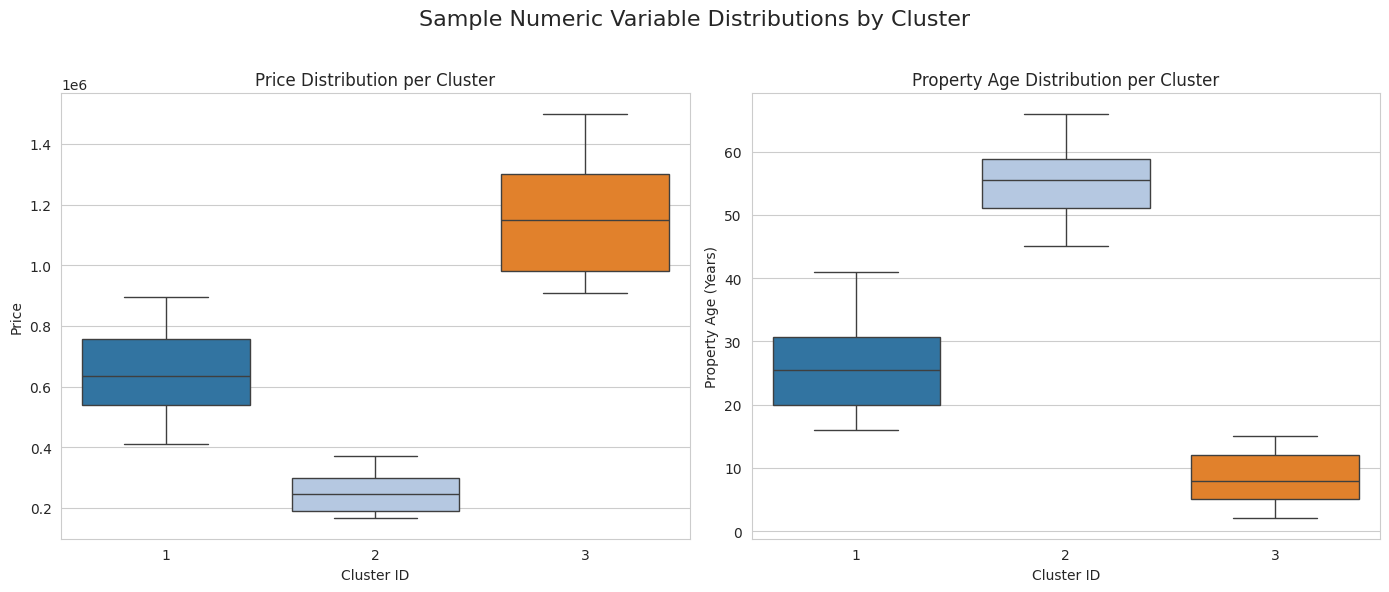

In [20]:
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))
plt.suptitle("Sample Numeric Variable Distributions by Cluster", fontsize=16)

# Boxplot for Price
plt.subplot(1, 2, 1)
# Assign 'cluster' to hue and turn off the redundant legend
sns.boxplot(
    x="cluster", y="price", data=df, hue="cluster", palette="tab20", legend=False
)
plt.title("Price Distribution per Cluster")
plt.ylabel("Price")
plt.xlabel("Cluster ID")

# Boxplot for Property Age
plt.subplot(1, 2, 2)
# Assign 'cluster' to hue and turn off the redundant legend
sns.boxplot(
    x="cluster", y="property_age", data=df, hue="cluster", palette="tab20", legend=False
)
plt.title("Property Age Distribution per Cluster")
plt.ylabel("Property Age (Years)")
plt.xlabel("Cluster ID")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Bar Charts for Categorical/Boolean Features

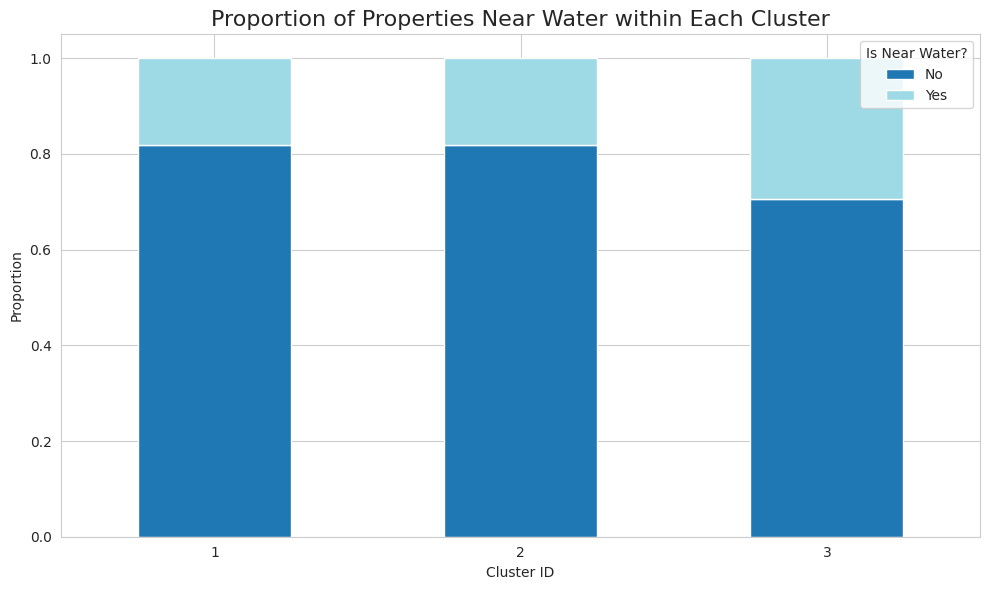

In [21]:
water_crosstab = pd.crosstab(df["cluster"], df["near_water"])

water_proportions = water_crosstab.div(water_crosstab.sum(axis=1), axis=0)

water_proportions.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")

plt.title("Proportion of Properties Near Water within Each Cluster", fontsize=16)
plt.xlabel("Cluster ID")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="Is Near Water?", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

---
## Generate Cluster Descriptions with Gemini

While the centroids and visualizations are useful, you can use generative AI to create human-readable descriptions for each cluster.

First, you'll aggregate the average statistics for each cluster into a pandas DataFrame.

In [22]:
%%bigquery df_cluster_stats --project {PROJECT_ID}

SELECT
  centroid_id AS cluster,
  AVG(price) AS avg_price,
  AVG(sq_ft) AS avg_sq_ft,
  AVG(year_built) AS avg_year_built,
  AVG(number_of_rooms) AS avg_number_of_rooms,
  AVG(number_of_baths) AS avg_number_of_baths,
  AVG(acre_lot) AS avg_acre_lot,
  AVG(property_age) AS avg_property_age,
  AVG(number_windows) AS avg_number_windows,
  COUNT(*) AS cluster_size
FROM
  ML.PREDICT(MODEL `housing_dataset.kmeans_clustering_model`,
    TABLE `housing_dataset.listings_multimodal`)
GROUP BY
  cluster
ORDER BY
  cluster;

Query is running:   0%|          |

Downloading:   0%|          |

### Prepare the prompt for Gemini

Next, you'll convert the statistics DataFrame into a simple string and create a prompt template. This prompt instructs the model to act as a real estate professional and provides a clear structure for the desired output.

In [23]:
# Convert the df_cluster_stats to a string for input to a Gemini model
cluster_info = df_cluster_stats.to_string()

# Define the prompt template
prompt = f"""You're a real estate professional. Come up with a description of each cluster.

Clusters:
{cluster_info}

For each cluster, please return:
1. A category for the cluster that describes the type of houses
2. A couple of summary statistics - average price and square footage
3. Key characteristics of the cluster
4. A target buyer
"""

### Generate cluster descriptions with a Gemini model

With the prompt and data prepared, you can now send the request to a Gemini model through the Vertex AI SDK to generate the descriptions.

In [24]:
from IPython.display import Markdown
from google import genai

LOCATION = "global"

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
)

# Display the response
display(Markdown(response.text))

Alright, let's break down these property clusters from a real estate perspective. It looks like we have distinct segments of the market here, each with its own appeal.

---

### **Cluster 1: The Modern Family Home**
*(Based on original Cluster 0)*

1.  **Category:** Established Suburban Homes / Modern Family Residences
2.  **Summary Statistics:**
    *   **Average Price:** ~$647,727
    *   **Average Square Footage:** ~2,572 sq ft
3.  **Key Characteristics:** This cluster represents spacious, relatively modern homes built around the turn of the millennium (average build year 2000). With nearly 3 bathrooms and a good number of rooms, these properties are well-suited for family living. They often come with a substantial lot size, close to an acre, offering privacy and outdoor space. These homes are likely to have a balanced blend of updated features and a comfortable, settled feel.
4.  **Target Buyer:** Growing families, professionals looking for more space and a good school district, or those seeking a comfortable, well-maintained home in an established suburban neighborhood with room to spread out.

---

### **Cluster 2: The Starter Home / Investment Opportunity**
*(Based on original Cluster 1)*

1.  **Category:** Affordable Entry-Level / Investment Properties
2.  **Summary Statistics:**
    *   **Average Price:** ~$250,454
    *   **Average Square Footage:** ~1,155 sq ft
3.  **Key Characteristics:** These are the most budget-friendly homes in our analysis, typically smaller in size and older, built around 1971 (average property age of 55 years). With fewer rooms and bathrooms, they offer a compact living experience on a quarter-acre lot. While older, the higher average number of windows suggests they might still offer decent natural light. These properties often require some updates but provide a strong foundation for customization.
4.  **Target Buyer:** First-time homebuyers, single individuals or couples, downsizers, or real estate investors looking for rental income or a fix-and-flip opportunity.

---

### **Cluster 3: The Luxury Estate**
*(Based on original Cluster 2)*

1.  **Category:** Premium Luxury Estates / New Construction Grand Homes
2.  **Summary Statistics:**
    *   **Average Price:** ~$1,156,471
    *   **Average Square Footage:** ~4,591 sq ft
3.  **Key Characteristics:** This cluster defines the high-end luxury market. These are substantial, very large homes, nearly double the size of Cluster 1, built very recently (average build year 2018, making them just 8-9 years old). They boast an impressive number of rooms and nearly 5 bathrooms, indicating high-end finishes and extensive living spaces. Situated on generous lots of almost 3 acres, these properties offer privacy, expansive outdoor areas, and modern amenities synonymous with new luxury construction. The high window count suggests bright interiors and architectural design focused on natural light.
4.  **Target Buyer:** Affluent families, high-net-worth individuals, those seeking modern luxury, custom-built homes, or move-up buyers looking for extensive space, privacy, and the prestige of a newer, large estate.

### Visualize a sample from each cluster

To complement the generated text descriptions, you can also visualize a sample image from each cluster. This gives a quick visual check on what a sample from each cluster looks like.

In [25]:
%%bigquery df_example_images --project {PROJECT_ID}

# Select one row per centroid_id and generate signed URLs

SELECT
  t1.centroid_id AS cluster,
  ANY_VALUE(t2.image_ref).uri AS uri,
  ANY_VALUE(t2.id) AS id
FROM
  ML.PREDICT(MODEL `housing_dataset.kmeans_clustering_model`, TABLE `housing_dataset.listings_multimodal`) AS t1
JOIN
  `housing_dataset.listings_multimodal` AS t2
ON
  t1.id = t2.id
GROUP BY
  cluster
ORDER BY
  cluster

Query is running:   0%|          |

Downloading:   0%|          |

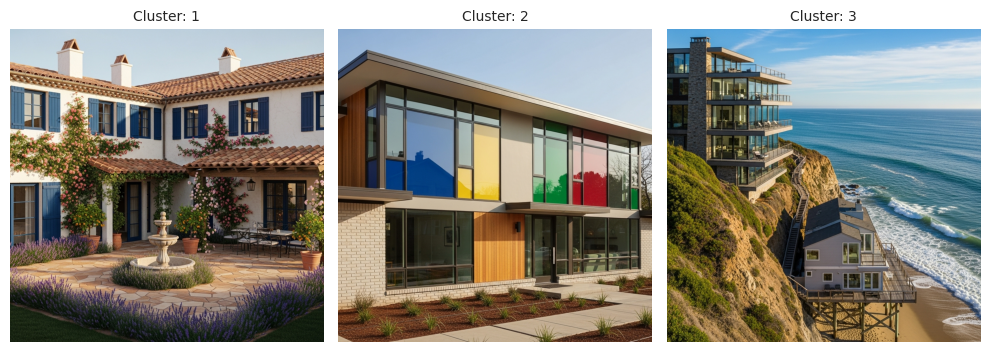

In [26]:
display_images(df_example_images, uri_column="uri", title_column="cluster")

---
## Automate Modeling with the Data Science Agent

Now, you'll explore a different approach to the same problem. Instead of writing SQL and Python code manually, you will use the integrated [**Data Science Agent**](https://cloud.google.com/bigquery/docs/colab-data-science-agent) to automatically generate code for a K-means clustering model.

This section is a placeholder to demonstrate where you would switch to the agent. In a live environment, you would open a new notebook and use the following prompt to have the agent build the model for you.

To use the Data Science Agent, follow these steps:
1. Follow [documentation steps](https://cloud.google.com/bigquery/docs/colab-data-science-agent#before_you_begin) to enable the proper APIs.
2. Open a new Colab Enterprise Notebook in BigQuery.
3. Open the Data Science Agent (it opens as a modal at the bottom of the screen or as a side pane).
4. Write `@housing_dataset.listings_multimodal` to @ select the proper table for context.
5. Give the Agent the following prompt and click-to-run the code that is generated: ```Use this table to generate a k-means clustering model to generate 3 clusters for housing listings. Then help me understand the characteristics of each of these clusters, so I can market to them as a real estate professional. Use Python.```
6. Feel free to ask follow-up questions, ask for SQL or Spark instead of Python, or simply play around with the integrated agent.
7. Once satisfied with the results, return back to this notebook for the next section.

---
## Multimodal Search with Embeddings and Vector Search

In this final section, you will use a multimodal embedding model to convert images into [vector embeddings](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-embedding#embeddings) and then use BigQuery's built-in [vector search](https://cloud.google.com/bigquery/docs/vector-search-intro) capabilities to find similar houses based on a text description or another image.

### Create a remote model for embeddings

Create a remote model that points to the [`multimodalembedding@001`](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings) model in Vertex AI. This model converts images and text into high-dimensional numeric vectors, known as embeddings.

In [27]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL housing_dataset.multimodal_embedding_model
REMOTE WITH CONNECTION DEFAULT
OPTIONS (ENDPOINT = 'multimodalembedding@001');

Executing query with job ID: af8a4f9f-c03c-4dfe-a4d4-21c645b52e3d
Query executing: 0.49s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/qwiklabs-gcp-03-52ef573f6140/queries/af8a4f9f-c03c-4dfe-a4d4-21c645b52e3d?maxResults=0&location=US&prettyPrint=false: com.google.apps.framework.request.StatusException: <eye3 title='INVALID_ARGUMENT'/> generic::INVALID_ARGUMENT: Exception calling IAM: Service account bqcx-35440820017-lspv@gcp-sa-bigquery-condel.iam.gserviceaccount.com does not exist.

Location: US
Job ID: af8a4f9f-c03c-4dfe-a4d4-21c645b52e3d



### Generate image embeddings

Use [`ML.GENERATE_EMBEDDING`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-embedding) to pass each house image to the model. This creates a new table, `home_embeddings`, containing the original image reference and its corresponding 1408-dimension vector embedding.

In [28]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE TABLE housing_dataset.home_embeddings AS
  SELECT
  id,
  price,
  sq_ft,
  prop_description,
  image_ref,
  ml_generate_embedding_result AS mm_embedding
FROM ML.GENERATE_EMBEDDING(
  MODEL housing_dataset.multimodal_embedding_model,
  (
    SELECT *, image_ref AS content from housing_dataset.listings_multimodal),
    STRUCT(TRUE AS flatten_json_output
  )
);

Executing query with job ID: f1b5d35b-eae7-4845-9cd7-0e0f5d2d6cc3
Query executing: 0.42s


ERROR:
 404 Not found: Model qwiklabs-gcp-03-52ef573f6140:housing_dataset.multimodal_embedding_model; reason: notFound, message: Not found: Model qwiklabs-gcp-03-52ef573f6140:housing_dataset.multimodal_embedding_model

Location: US
Job ID: f1b5d35b-eae7-4845-9cd7-0e0f5d2d6cc3



### Review the generated embeddings

Run a quick `SELECT` query to inspect the `home_embeddings` table. This is a good practice to verify that the `mm_embedding` column was created correctly before you build an index on it.

In [29]:
%%bigquery --project {PROJECT_ID}

SELECT *
FROM housing_dataset.home_embeddings
LIMIT 2

Executing query with job ID: a72a6e85-a8a3-43ce-88b1-8059d0acb40d
Query executing: 0.37s


ERROR:
 404 Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US; reason: notFound, message: Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US

Location: US
Job ID: a72a6e85-a8a3-43ce-88b1-8059d0acb40d



### Create a vector index for efficient search

To enable fast and scalable similarity searches, create a [`VECTOR INDEX`](https://cloud.google.com/bigquery/docs/vector-index) on the embedding column. The index allows BigQuery to find the nearest neighbors much more efficiently than a full table scan.

Vector indexes are ideal for large datasets. Because we only have ~80 records here, we'll get an error that our data isn't large enough to benefit from an index.

In [30]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE
  VECTOR INDEX `house_images_index`
ON
  housing_dataset.home_embeddings(mm_embedding)
  OPTIONS (
    index_type = 'IVF',
    distance_type = 'COSINE');

Executing query with job ID: a116ecbf-549a-4f3c-bc36-1c45410d9995
Query executing: 0.58s


ERROR:
 404 Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US; reason: notFound, message: Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US

Location: US
Job ID: a116ecbf-549a-4f3c-bc36-1c45410d9995



### Perform text-to-image search

Now, perform a similarity search using [`VECTOR_SEARCH`](https://cloud.google.com/bigquery/docs/reference/standard-sql/search_functions#vector_search). A subquery first generates an embedding for the text "house near the ocean" and the main query then finds the 3 images whose embeddings are most similar to that text query.

Note that we're searching text-to-image without using metadata tags on the images.

In [31]:
%%bigquery text_to_image_df --project {PROJECT_ID}

SELECT base.image_ref.uri
    FROM
      VECTOR_SEARCH(
        TABLE `housing_dataset.home_embeddings`,
        'mm_embedding',
        (
        -- GENERATE AN EMBEDDING AS A SUBQUERY
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL housing_dataset.multimodal_embedding_model,
            ( SELECT "house near the ocean" AS content)
          )
        ),
        top_k => 3)
ORDER BY distance ASC;

Executing query with job ID: 0d4d9ca3-f554-4e4c-8e56-50acff52bd9b
Query executing: 0.33s


ERROR:
 404 Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US; reason: notFound, message: Not found: Table qwiklabs-gcp-03-52ef573f6140:housing_dataset.home_embeddings was not found in location US

Location: US
Job ID: 0d4d9ca3-f554-4e4c-8e56-50acff52bd9b



Next, let's visualize the top results returned from the `VECTOR_SEARCH`.

In [32]:
display_images(text_to_image_df)

TypeError: object of type 'QueryJob' has no len()

### Perform image-to-image search

The process for image-to-image search is nearly identical. Instead of using a text string, the subquery generates an embedding for a sample image URI, and `VECTOR_SEARCH` finds the most visually similar images.

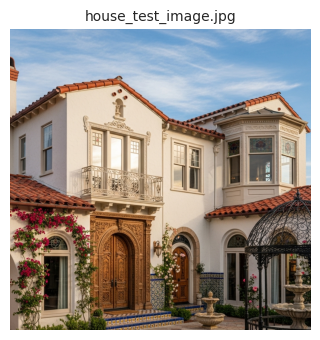

In [33]:
# Get a sample house image from GCS
sample_house = f"gs://{bucket_name}/images/test_image/house_test_image.jpg"
image_df = pd.DataFrame({"uri": [sample_house]})
display_images(image_df)

In [ ]:
%%bigquery image_to_image_df --project {PROJECT_ID}

SELECT base.image_ref.uri
    FROM
      VECTOR_SEARCH(
        TABLE `housing_dataset.home_embeddings`,
        'mm_embedding',
        (
        -- GENERATE AN EMBEDDING AS A SUBQUERY
        SELECT
          ml_generate_embedding_result,
          content AS query
        FROM
          ML.GENERATE_EMBEDDING(
            MODEL housing_dataset.multimodal_embedding_model,
            ( SELECT OBJ.FETCH_METADATA(OBJ.MAKE_REF('gs://drw001-data-science-with-notebooks/images/test_image/house_test_image.jpg', 'us.ai_connection')) AS content)
          )
        ),
        top_k => 3)
ORDER BY distance ASC;

Visualize the results from the image-to-image vector search.

In [ ]:
display_images(image_to_image_df)

---


## Cleaning Up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created:

In [ ]:
# Delete the BigQuery tables
!bq rm --table -f housing_dataset.listings
!bq rm --table -f housing_dataset.listings_multimodal
!bq rm --table -f housing_dataset.home_embeddings

# Delete the remote model
!bq rm --model -f housing_dataset.gemini
!bq rm --model -f housing_dataset.kmeans_clustering_model
!bq rm --model -f housing_dataset.multimodal_embedding_model

# Delete the remote connection
!bq rm --connection --project_id=$PROJECT_ID --location=us ai_connection

# Delete the BigQuery dataset
!bq rm -r -f $PROJECT_ID:housing_dataset